### NDVI with sentinel 2

Here is the code for NDVI using sentinel 2. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

import shapely.wkt
import shapely.geometry
from shapely import wkt

import collections
collections.Callable = collections.abc.Callable

import warnings
warnings.filterwarnings('ignore')

import os
from osgeo import gdal
from osgeo import ogr
import rasterio as rio

In [2]:
import ee
#The first time you use the earthengine module, you need to link your account credentials. Afterwards, your
#computer stores the authentication file

#ee.Authenticate()
#/home/username/credentials/earthengine/

ee.Initialize()
print(ee.__version__)

0.1.306


Debo agregar:
- shapefile para recortar 
- tiempo
- collection


## Functions

In [3]:
##Function to processing the data
from gee_defs_short import *

In [4]:
def addtime(image):
    date = ee.Date(image.get('system:time_start'))
    years = date.difference(ee.Date('2017-01-01'), 'day')  #cambie aca la fecha
    return image.addBands(ee.Image(years).rename('t')).float().addBands(ee.Image.constant(1)) #Note we also add a constant here!

In [5]:
def run_export(image, crs, filename, scale, region, maxPixels=1e12, cloud_optimized=True):
    '''
    Runs an export function on GEE servers. 
    Image: The image to export (e.g., long-term mean, water mask, etc)
    crs: The projection (e.g., image.projection())
    filename: The output name WITHOUT the .tif extension
    scale: The pixel size at the end (in meters, e.g., 30, 100, 500)
    region: The export region (e.g., a polygon)
    '''
    task_config = {'fileNamePrefix': filename,'crs': crs,'scale': scale,'maxPixels': maxPixels, 
                   'fileFormat': 'GeoTIFF', 'formatOptions': {'cloudOptimized': cloud_optimized}, 
                   'region': region,}
    task = ee.batch.Export.image.toDrive(image, filename, **task_config)
    task.start()

In [6]:
def percentile_reg(collection, band_name, percentiles):
    trend_images = []
    for p in percentiles:
        bands = ['constant', 't', band_name + '_p%i' % p]
        fit = collection.select(bands).reduce(ee.Reducer.robustLinearRegression(numX=2, numY=1))
        #fit = collection.select(bands).reduce(ee.Reducer.linearRegression(numX=2, numY=1))
        #fit = collection.select(bands).reduce(ee.Reducer.linearFit())
        #Note -- linearRegression and robustLinearRegression both also have 'residuals' to help you assess the fits
        lrImage = fit.select(['coefficients']).arrayProject([0]).arrayFlatten([['constant', 'trend']])\
            .select('trend')
        trend_images.append(lrImage)
    output_image = ee.ImageCollection.fromImages(trend_images).toBands().rename(['p_' + str(x) for x in percentiles])
    return output_image

In [7]:
def reduce_pct(collection, percentile, date_start, date_end, timeframe='month', skip=1):
    def reduce_pctile(filt_coll):
        filt_coll = ee.ImageCollection(filt_coll)
        t = filt_coll.get('system:time_start')
        agg = filt_coll.reduce(ee.Reducer.percentile(percentile)).set('system:time_start', t)
        return agg
    
    pctile = aggregate_to(collection, date_start, date_end, timeframe=timeframe, skip=skip, agg_fx=reduce_pctile)
    return pctile

In [8]:
def maskBorder(image):
    totalSlices = ee.Number(image.get('totalSlices'))
    sliceNumber = ee.Number(image.get('sliceNumber'))
    middleSlice = ee.Image(sliceNumber.gt(1).And(sliceNumber.lt(totalSlices)))
    mask = image.select(['VV', 'VH']).mask().reduce(ee.Reducer.min()).floor()
    pixelsToMask = mask.Not().fastDistanceTransform(128, 'pixels').sqrt()
    metersToMask = pixelsToMask.multiply(ee.Image.pixelArea().sqrt()).rename('metersToMask')
    notBorder = metersToMask.gte(500).And(pixelsToMask.gt(2))
    angle = image.select('angle')
    return image.updateMask(angle.gt(31).And(angle.lt(45)).And(middleSlice.Or(notBorder)))    

### shapefiles

In [9]:
ID=8

if ID==2:
    ds = '2019-09-01' #start
    de = '2020-09-01' #end

if ID==3:
    ds = '2018-09-01' #start
    de = '2019-09-01' #end

if ID==4:
    ds = '2018-09-01' #start
    de = '2019-09-01' #end
    
if ID==5:
    ds = '2018-09-01' #start
    de = '2019-09-01' #end
    
if ID==8:
    ds = '2018-09-01' #start
    de = '2019-09-01' #end

In [10]:
label_fp='C:/Users/Flores/Documents/PythonScripts/codigos/Thesis/info_vectorial/Management/field_outlines/field_outlines.shp'
# now load the shapefile using geopandas and check it's projection
shapefile = gpd.read_file(label_fp)

# print the head
print(shapefile.head(10))

print('\nthere are {} labels'.format(len(shapefile)))

# shapefile = shapefile.to_crs({'init': 'epsg:25832'})
print('\nprojection is: {}'.format(shapefile.crs))

   field id  field size                                           geometry
0         1        2.58  POLYGON ((12.93462 50.56671, 12.93530 50.56689...
1         2       65.97  POLYGON ((13.09766 51.33932, 13.09883 51.33933...
2         3       14.90  POLYGON ((11.74763 53.06296, 11.75287 53.06308...
3         4       11.69  POLYGON ((10.83685 49.47271, 10.83782 49.47295...
4         6        3.81  POLYGON ((11.67589 50.17714, 11.67630 50.17699...
5         7        8.34  POLYGON ((11.81317 50.35535, 11.81358 50.35530...
6         8       56.03  POLYGON ((13.91466 52.77635, 13.91523 52.77651...
7         9       60.26  POLYGON ((13.91132 52.76778, 13.91159 52.76782...
8         5       13.48  POLYGON ((11.99882 49.08490, 11.99907 49.08465...

there are 9 labels

projection is: epsg:4326


In [11]:
test2=shapefile.loc[shapefile['field id']==ID]
test2

field id  field size                                           geometry
6         8       56.03  POLYGON ((13.91466 52.77635, 13.91523 52.77651...

In [12]:
geoms_test2 = pd.DataFrame(test2['geometry'])
(geoms_test2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 6 to 6
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  1 non-null      geometry
dtypes: geometry(1)
memory usage: 16.0 bytes



and this shape looks like:


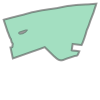

In [13]:
# this generates a list of shapely geometries
geoms_test2 = test2.geometry.values 
# to show you what this looks like let's grab a random polygon in the shapefile
geometry_test2 = geoms_test2[0] 
print('\nand this shape looks like:')
geometry_test2

In [14]:
list_wkt = test2.geometry.apply(lambda x: wkt.dumps(x))
list_wkt

6    POLYGON ((13.9146599029092979 52.7763544282206...
Name: geometry, dtype: object

In [15]:
list_polygons =  [shapely.wkt.loads(poly) for poly in list_wkt]

list_multipolygons= shapely.geometry.MultiPolygon(list_polygons) 

In [16]:
list_multipolygons.centroid.x

13.921543984241325

In [17]:
cenxp2, cenyp2 = list_multipolygons.centroid.x, list_multipolygons.centroid.y
aoi_geep2 = gee_geometry_from_shapely(list_multipolygons)

In [18]:
print(cenxp2, cenyp2)

13.921543984241325 52.77476289434535


## Sentinel 2

In [19]:
# Centroid = ee.Geometry.Point([13.389833, 52.505624])
# clipper = Centroid.buffer(3000) #This is in METERS

S2 = ee.ImageCollection("COPERNICUS/S2_SR")\
        .filter(ee.Filter.date(ds, de))\
        .filterBounds(aoi_geep2)

#print(L8)
metadata = S2.getInfo()
#print(metadata)

ims = metadata['features']
#print(ims)


# recordar que no javascript y python son parecidos, pero aca se ve una diferencia

images = S2.toList(S2.size())
num_images = len(images.getInfo())
print(num_images)
num_images=S2.size().getInfo()
print(num_images)


145
145


We can now loop through each of these images and pull a grid location into an array:

In [20]:
def NDVI(img):
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return img.addBands(ndvi).select('NDVI')

In [21]:
img = ee.Image(images.get(0))
#print(img)
ndvi = NDVI(img)
#print(ndvi)
clip = ndvi.sampleRectangle(region=aoi_geep2 ,defaultValue=0)
data = clip.getInfo()

In [22]:
data
arr = np.array(data['properties']['nd'])
print(arr.shape)

(93, 94)


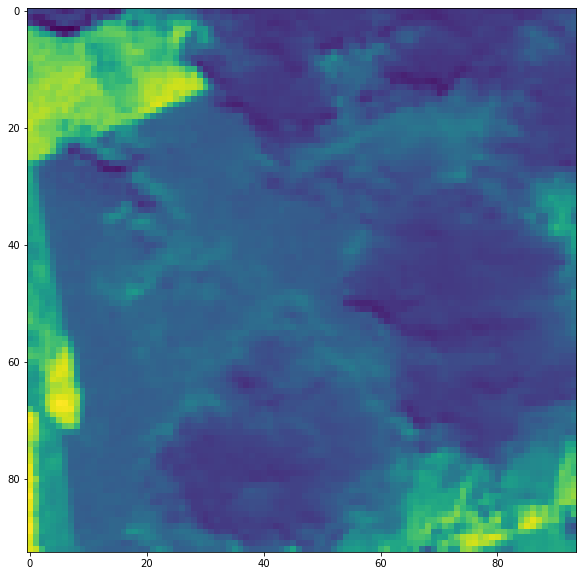

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(arr)

In [24]:
out = np.empty((93,94,num_images))
# for i in range(50):
for i in range(num_images):
    img = ee.Image(images.get(i))
    ndvi = NDVI(img)
    clip = ndvi.sampleRectangle(region=aoi_geep2 ,defaultValue=0)
    data = clip.getInfo()
    
    #print(data)
    arr = np.array(data['properties']['nd'])
    
    out[:,:,i] = arr
#     print(i)

(93, 94, 145)

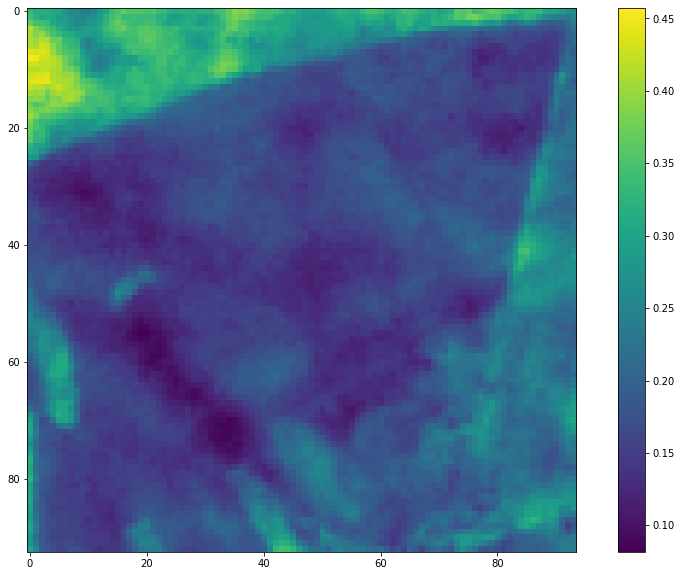

In [25]:
##looking individual data
plt.figure(figsize=(15,10))
a = plt.imshow(out[:,:,8])
plt.colorbar(a)

out.shape

In [26]:
ndvi=S2.map(NDVI)
ndvi_mean=ee.Image(ndvi.reduce(ee.Reducer.mean()))
clip = ndvi_mean.sampleRectangle(region=aoi_geep2 ,defaultValue=0)
data = clip.getInfo()
print(data)

{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'MultiPolygon', 'coordinates': [[[[13.914659902909298, 52.77635442822061], [13.915225989197893, 52.776508844459336], [13.915671951075115, 52.77662965207595], [13.91602932119895, 52.77672684292261], [13.91629209334883, 52.77678497566177], [13.916709525678352, 52.77689760762292], [13.917616464984215, 52.777112879189396], [13.917885994132234, 52.77719916918084], [13.91849262240967, 52.77736084891478], [13.918690827688435, 52.77742533897818], [13.918872515860636, 52.777469846149316], [13.919292951300443, 52.77754251082069], [13.919630801207429, 52.777618808595065], [13.920329024348534, 52.77775505428809], [13.920626332266686, 52.77779683621517], [13.921229957433836, 52.77788857465348], [13.921746492402741, 52.7779612386258], [13.922202965165958, 52.77802572779961], [13.922525048743955, 52.778072050950016], [13.923019060385732, 52.77817786740631], [13.924026603886123, 52.77837587512181], [13.924531126413891, 52.77842764760972], [13

Text(0.5, 1.0, 'Max')

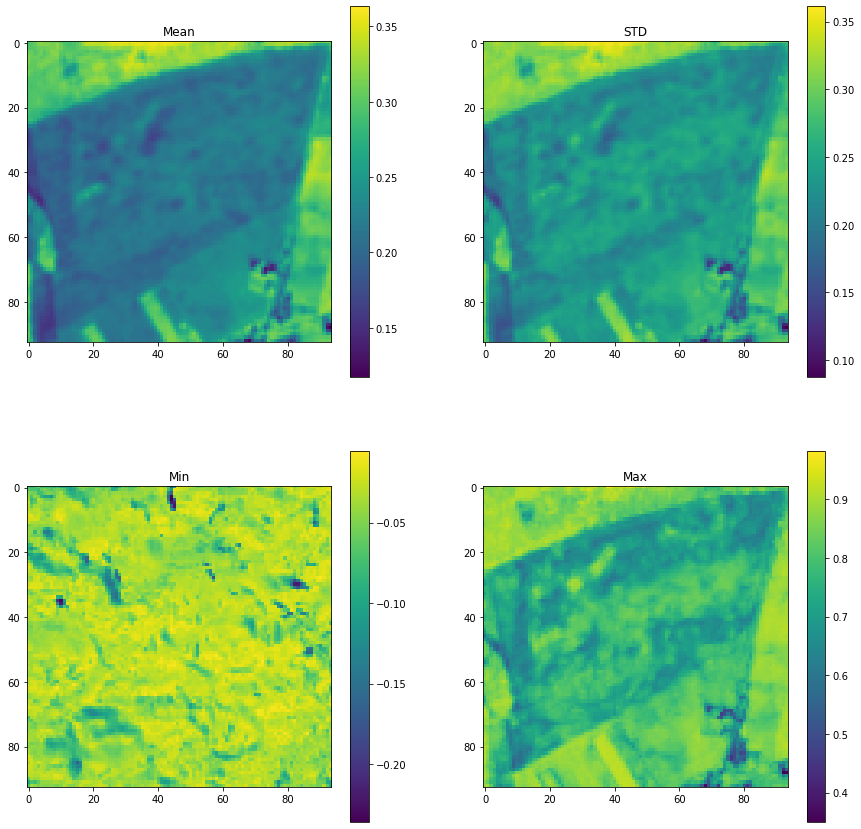

In [27]:
#Take a look at your results.
import matplotlib.pyplot as plt
    
plt.close('all')
f, ((ax, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,15))
a = ax.imshow(np.nanmean(out, 2))
plt.colorbar(a, ax=ax)
ax.set_title('Mean')

a = ax2.imshow(np.nanstd(out, 2))
plt.colorbar(a, ax=ax2)
ax2.set_title('STD')
        
a = ax3.imshow(np.nanmin(out, 2))
plt.colorbar(a, ax=ax3)
ax3.set_title('Min')

a = ax4.imshow(np.nanmax(out, 2))
plt.colorbar(a, ax=ax4)
ax4.set_title('Max')


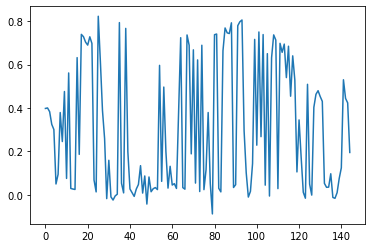

In [28]:
plt.plot(out[92,93,:])

## 6. Example – Pulling Time Series at a Location

While in some cases it is useful to pull a set of images off of GEE, often we are more interested in some statistics about those images – for example, we don’t really need to see the whole Berlin area as a plot if we are interested in how NDVI changes over time. We could just as easily download the mean and standard deviation of each image in our list and make time series plots with that. This is a highly efficient way to push more of the processing back onto GEE – we only download a very short list of dates and values at the end of the processing chain. 


In [29]:
#Prepare helper functions
def rescale(image):
    date = image.get('system:time_start')
    return image.multiply(scale_factor).set('system:time_start', date)

def createTS(image):
    date = image.get('system:time_start')
    value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=ROI).get(var)
    std = image.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=ROI).get(var)
    ft = ee.Feature(None, {'date': ee.Date(date).format('Y/M/d'), var: value, 'STD': std})
    return ft

def TS_to_pandas(TS):
    dump = TS.getInfo()
    fts = dump['features']
    out_vals = np.empty((len(fts)))
    out_dates = []
    out_std = np.empty((len(fts)))
    
    for i, f in enumerate(fts):
        props = f['properties']
        date = props['date']
        val = props[var]
        std = props['STD']
        out_vals[i] = val
        out_std[i] = std
        out_dates.append(pd.Timestamp(date))
    
    ser = pd.Series(out_vals, index=out_dates)
    return ser, out_std

In [35]:
def maskcloud1(image):
    QA60 = image.select(['QA60'])
    return image.updateMask(QA60.eq(0))

In [36]:
ROI=aoi_geep2
var='NDVI'
S2_mask=S2.map(maskcloud1)
ndvi = S2_mask.map(NDVI_S2)
TS = ndvi.map(createTS)
print(TS.getInfo())

{'type': 'FeatureCollection', 'columns': {}, 'id': 'COPERNICUS/S2_SR', 'version': 1657691326515866, 'properties': {'date_range': [1490659200000, 1647907200000], 'period': 0, 'system:visualization_0_min': '0.0', 'type_name': 'ImageCollection', 'keywords': ['copernicus', 'esa', 'eu', 'msi', 'reflectance', 'sentinel', 'sr'], 'system:visualization_0_bands': 'B4,B3,B2', 'thumb': 'https://mw1.google.com/ges/dd/images/COPERNICUS_S2_SR_thumb.png', 'description': '<p>Sentinel-2 is a wide-swath, high-resolution, multi-spectral\nimaging mission supporting Copernicus Land Monitoring studies,\nincluding the monitoring of vegetation, soil and water cover,\nas well as observation of inland waterways and coastal areas.</p><p>The Sentinel-2 L2 data are downloaded from scihub. They were\ncomputed by running sen2cor. WARNING: ESA did not produce L2 data\nfor all L1 assets, and earlier L2 coverage is not global.</p><p>The assets contain\n12 UINT16 spectral bands representing SR scaled by 10000 (unlike in 

La linea anterior es para explicar lo que las definiciones de arriba reducen, y permiten manipular. Aca se ve la explicacion de la estructura de los archivos

In [39]:
TS

<AxesSubplot:>

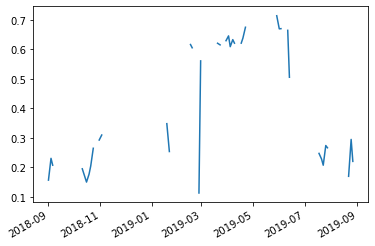

In [49]:
ser, std = TS_to_pandas(TS)
ser.plot()


In [50]:
print(ser.values)

[0.15659629 0.23039944 0.20715048        nan        nan        nan
        nan 0.19305565        nan 0.23703444        nan 0.20933005
        nan        nan        nan 0.19851218        nan 0.19497356
 0.16816718 0.14998348 0.17658648 0.2046569  0.26454337        nan
        nan 0.29238305 0.30939859        nan        nan        nan
 0.11862561        nan        nan        nan        nan 0.49874933
        nan        nan 0.52379529        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.1152763         nan        nan        nan        nan
 0.41866476        nan 0.34786841 0.25348578        nan        nan
        nan        nan        nan        nan 0.60170493        nan
        nan 0.61601824 0.6049312         nan        nan 0.11294083
 0.56054629        nan 0.55048149        nan        nan        nan
        nan        nan 0.62036775 0.61478075        nan        nan
 0.6289419  0.64521426 0.60870737 0.63256594 0.6205087        

<AxesSubplot:>

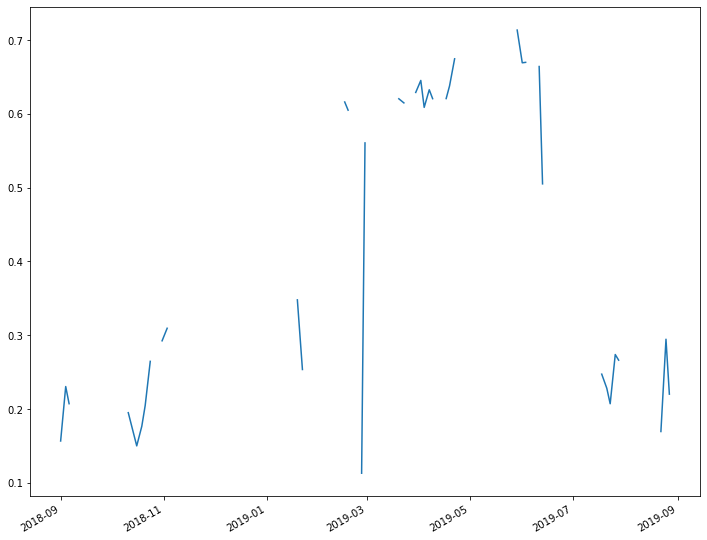

In [38]:
ndvi_ts, ndvi_std = TS_to_pandas(TS)
ndvi_ts.plot(figsize=(12,10))

In [34]:
S2_mask2=S2.map(maskcloud1)
S2_2 = S2_mask2.map(NDVI_S2)
NDVI2 = S2_2.select(['nd'])
NDVImed = NDVI2.median()

TS2 = NDVI2.map(createTS)

In [69]:
NDVI_inter=ser.interpolate(method='linear', order=3)

In [70]:
NDVI_inter

2018-09-01    0.156596
2018-09-04    0.230399
2018-09-06    0.207150
2018-09-09    0.204332
2018-09-11    0.201513
                ...   
2019-08-20    0.155076
2019-08-22    0.169449
2019-08-25    0.294528
2019-08-27    0.220082
2019-08-30    0.220082
Length: 145, dtype: float64

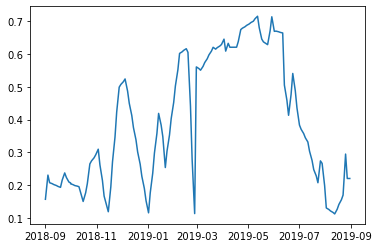

In [71]:
plt.plot(NDVI_inter)

In [74]:
from smooth_fx import *

wind=5
order=1

NDVI_SG=savitzky_golay(NDVI_inter.values, wind,order, deriv=0, rate=1)

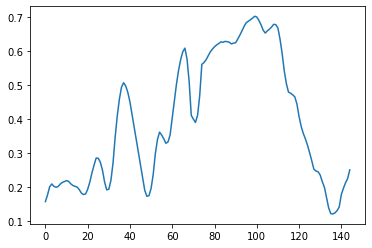

In [75]:
plt.plot(NDVI_SG)